# NLP: Vector Space Semantics for Similarity between Eastenders Characters


In [509]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [510]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline
pd.options.display.max_colwidth=500

In [511]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
display(all_train_data)
all_train_data.info()
print("number of scenes where each character appeared:")
display(all_train_data.groupby(['Character_name'])['Scene'].count())
display(all_train_data['Scene_info'].value_counts())

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15319 entries, 0 to 15318
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Episode         15319 non-null  int64 
 1   Scene           15319 non-null  int64 
 2   Scene_info      15319 non-null  object
 3   Character_name  15319 non-null  object
 4   Line            15307 non-null  object
 5   Gender          15319 non-null  object
dtypes: int64(2), object(4)
memory usage: 718.2+ KB
number of scenes where each character appeared:


Character_name
CHRISTIAN     385
CLARE         405
HEATHER       448
IAN           909
JACK          594
JANE          671
MAX           690
MINTY         456
OTHER        6369
PHIL          500
RONNIE        534
ROXY          413
SEAN          506
SHIRLEY       572
STACEY        625
TANYA        1242
Name: Scene, dtype: int64

CAFE INT DAY LIGHT                                949
VIC DOWNSTAIRS INT DAY LIGHT                      830
BRIDGE STREET EXT DAY LIGHT                       808
[NAME] & [NAME]'S HOUSE INT DAY LIGHT             719
VIC DOWNSTAIRS INT NIGHT                          634
                                                 ... 
[NAME] & [NAME]'S HOUSE - LOUNGE INT DAY LIGHT      1
[NAME]'S SHARED HOUSE EXT DAY LIGHT                 1
CAFE EXT DAY LIGHT                                  1
MORTUARY WAITING ROOM INT NIGHT                     1
BRANNINGS' HOUSE, HALLWAY INT DAY LIGHT             1
Name: Scene_info, Length: 244, dtype: int64

In [512]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [513]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [514]:
train_data
#len(episode_scene_values)

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [515]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [516]:
episode_scene_values = all_train_data['episode_scene'].unique()
print(episode_scene_values[1:])

['1350-2' '1350-4' '1350-6' ... '1399-48' '1399-51' '1399-55']


On observing the dataset, we can use the line said by another character as before and after context. The line can be extracted using the episode_scene column we added to make sure we only consider the lines from the same scene as context.

In [517]:
def get_dialog_context(df):
    '''Add before_context and after_context column having the line 
    said before and after the character's line in the same scene.'''

    episode_scene_values = df['episode_scene'].unique()
    
    before_context = (df[df["episode_scene"]==episode_scene_values[0]]['Line'].shift(1))
    after_context = (df[df["episode_scene"]==episode_scene_values[0]]['Line'].shift(-1))
    #print(episode_scene_values)
    for episode_scene_value in episode_scene_values[1:]:
        before = (df[df["episode_scene"]==episode_scene_value]['Line'].shift(1))
        after = (df[df["episode_scene"]==episode_scene_value]['Line'].shift(-1))
        before_context = pd.concat([before_context,before],ignore_index=True)
        after_context = pd.concat([after_context,after],ignore_index=True)
    df['before_context'] = before_context
    df['after_context'] = after_context
    return df

In [518]:
#display(get_dialog_context(all_train_data))

In [519]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    
    #Calling get_dialog_context to add context column in the current dataset
    df = get_dialog_context(df)
    
    character_docs = {}
    character_line_count = {}
    before_context = {}
    after_context = {}
    scene_info = {}
    extra_features = {}
    
    for line, name, before, after, scene in zip(df.Line, df.Character_name,df.before_context, df.after_context,df.Scene_info):
        if not name in character_docs.keys():
            character_docs[name] = ""
            before_context[name] = ""
            after_context[name] = ""
            scene_info[name] = {}
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
        
        if not scene in scene_info[name].keys():
            scene_info[name][scene] = 0
        scene_info[name][scene] += 1
        
        #Checking for nan values because if the line is the first line in scene it will be nan value
        if pd.isna(before)==False:
            before_context[name] += str(before)   + " _EOL_ "
        #Checking for nan values because if the line is the last line in scene it will be nan value
        if pd.isna(after)==False:
            after_context[name] += str(after)   + " _EOL_ "
            
    #Creating extra_features dict using scene_info, before_context and after_context
    header = ["scene_info","before_context","after_context"]
    
    for name in before_context:
        extra_features[name] = {feat_name: feat_value for feat_name,feat_value in zip(header,[scene_info[name],before_context[name],after_context[name]])}
    print(extra_features.keys())    
    print("lines per character", character_line_count)
    return (character_docs,extra_features)

In [520]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs,extra_features = create_character_document_from_dataframe(get_dialog_context(train_data), max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

<ipython-input-517-20e39806fcad>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['before_context'] = before_context
<ipython-input-517-20e39806fcad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_context'] = after_context


dict_keys(['SHIRLEY', 'OTHER', 'JACK', 'RONNIE', 'TANYA', 'SEAN', 'ROXY', 'HEATHER', 'MAX', 'IAN', 'JANE', 'STACEY', 'PHIL', 'MINTY', 'CHRISTIAN', 'CLARE'])
lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [521]:
#print(train_character_docs)
#print(extra_features)

<h3>Preprocessing</h3>

In [522]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [523]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def separating_punctuation(text):
    '''Separating out the punctuation'''
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    return text

def remove_puntuation(text):
    '''Remove punctuation from the lines'''
    return re.sub(r'[^\w\s]', '', text)

def convert_to_lowercase(tokens):
    '''Convert all the tokens to lower case''' 
    return [token.lower() if token.isalpha() else token for token in tokens]

def remove_stopwords(tokens):
    '''Remove stop words i.e. the words that occur commonly. stopword from nltk is used for this step'''
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

def apply_lemmatization(tokens):
    '''Lemmatize the token i.e. switches the word to its base root'''
    wnl=WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens]
    return tokens

def apply_stemming(tokens, ps=PorterStemmer()):
    '''Stemming the token to reduce it to its base form.'''
    return [ps.stem(t) for t in tokens]

In [524]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    #character_text = separating_punctuation(character_text)
    
    character_text = remove_puntuation(character_text)
    
    tokens = character_text.split()
    
    #tokens = convert_to_lowercase(tokens)
    
    tokens = remove_stopwords(tokens)
    
    tokens = apply_lemmatization(tokens)
    
    #tokens = apply_stemming(tokens)
    
    #print(tokens)
    return tokens

In [525]:
# create list of pairs of (character name, pre-processed character) 

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
#print(extra_features)

<h3>Feature Extraction</h3>

In [526]:
#_WEIGHT_ = "binary"
#_WEIGHT_ = "weighted"
_WEIGHT_ = "counts"
_N_ =  2

In [527]:
#For adding extra featues
add_scene_info = True
add_before_context = False
add_after_context = False

In [528]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    feature_vector_dict =  Counter()  # local feature vector for counts
    tokens = character_doc
    # collect the counts for all n in range (1,_N_)
    for n in range(1,_N_+1):
        new_tokens = ["<s>"]*(n-1) + tokens + ["</s>"]
        
        for i in range(n-1, len(new_tokens)):
            raw_ngram = " ".join(new_tokens[i-(n-1):i+1])
            #print(raw_ngram)
            n_gram = "{}@{}".format(n, raw_ngram)
            #print(n_gram)
            feature_vector_dict[n_gram]+=1
    
    # if _WEIGHT_ is 'counts' then this has already been done
    if _WEIGHT_ == "binary":
        feature_vector_dict = {x:1 for x in feature_vector_dict.keys()}  # binary Set-of-Words
    elif _WEIGHT_ == "weighted":
        # bag-of-words counts 
        feature_vector_dict = {x:feature_vector_dict[x]/(len(tokens)+1) for x in feature_vector_dict.keys()}
    elif _WEIGHT_ == 'counts':
        feature_vector_dict = dict(feature_vector_dict)
    
    # add scene info counts/weights
    if add_scene_info == True:
        scene_info = extra_features["scene_info"]
        if _WEIGHT_ == "binary":
            scene_info = {x:1 for x in scene_info.keys()}  # binary Set-of-Words
        elif _WEIGHT_ == "weighted":
            scene_info = {x:scene_info[x]/(len(scene_info)+1) for x in scene_info_counts.keys()}
        feature_vector_dict.update(scene_info)
        
    # add before context counts/weights
    if add_before_context == True:
        before_context = extra_features["before_context"]
        before_context_tokens = pre_process(before_context)
        before_context_counts = dict(Counter(before_context_tokens))

        before_context_counts = {"before_context_" + word : count for word,count in before_context_counts.items()}
        if _WEIGHT_ == "binary":
            before_countext_counts = {x:1 for x in before_context_counts.keys()}  # binary Set-of-Words
        elif _WEIGHT_ == "weighted":
            before_countext_counts = {x:before_context_counts[x]/(len(before_context_tokens)+1) for x in before_context_counts.keys()} 
        feature_vector_dict.update(before_context_counts)
    
    # add after context counts/weights
    if add_after_context == True:
        after_context = extra_features["after_context"]
        after_context_tokens = pre_process(after_context)
        after_context_counts = dict(Counter(after_context_tokens))
        after_context_counts = {"after_context_" + word : count for word,count in after_context_counts.items()}
        if _WEIGHT_ == "binary":
            after_context_counts = {x:1 for x in after_context_counts.keys()}  # binary Set-of-Words
        elif _WEIGHT_ == "weighted":
            after_context_counts = {x:after_context_counts[x]/(len(after_context_tokens)+1) for x in after_context_counts.keys()} 
        feature_vector_dict.update(after_context_counts)
    
    #print(extra_features.keys())    
    #print(feature_vector_dict)    
    return feature_vector_dict  

In [529]:
# counts = [to_feature_vector_dictionary(doc, extra_features[name]) for name, doc in training_corpus]
# print(counts)

In [530]:
#print(counts[0])

In [531]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts

tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    # uses the global variable of the corpus Vectorizer to improve things
    # if fitting:
    #     corpusVectorizer.fit([to_feature_vector_dictionary(doc, extra_features[name]) for name, doc in corpus])
    # doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, extra_features[name]) for name, doc in corpus])
    
    #Using tf idf transform to improve the performance
    if fitting:
        vect_corpus = corpusVectorizer.fit_transform([to_feature_vector_dictionary(doc, extra_features[name]) for name, doc in corpus])
        doc_feature_matrix = tfidf_transformer.fit_transform(vect_corpus)
    else:
        vect_corpus = corpusVectorizer.transform([to_feature_vector_dictionary(doc, extra_features[name]) for name, doc in corpus])    
        doc_feature_matrix = tfidf_transformer.transform(vect_corpus)
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [532]:
training_feature_matrix

<16x29221 sparse matrix of type '<class 'numpy.float64'>'
	with 47085 stored elements in Compressed Sparse Row format>

In [533]:
# get the validation data- only 40 lines used for each character
val_character_docs,extra_features = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

#create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

dict_keys(['TANYA', 'MAX', 'SEAN', 'SHIRLEY', 'OTHER', 'STACEY', 'RONNIE', 'JACK', 'PHIL', 'IAN', 'JANE', 'ROXY', 'HEATHER', 'MINTY', 'CHRISTIAN', 'CLARE'])
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


<ipython-input-517-20e39806fcad>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['before_context'] = before_context
<ipython-input-517-20e39806fcad>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_context'] = after_context


In [534]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [535]:
val_feature_matrix

<16x29221 sparse matrix of type '<class 'numpy.float64'>'
	with 4453 stored elements in Compressed Sparse Row format>

In [536]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [537]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [538]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [539]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.75
mean cosine similarity 0.6702491454033326
12 correct out of 16 / accuracy: 0.75


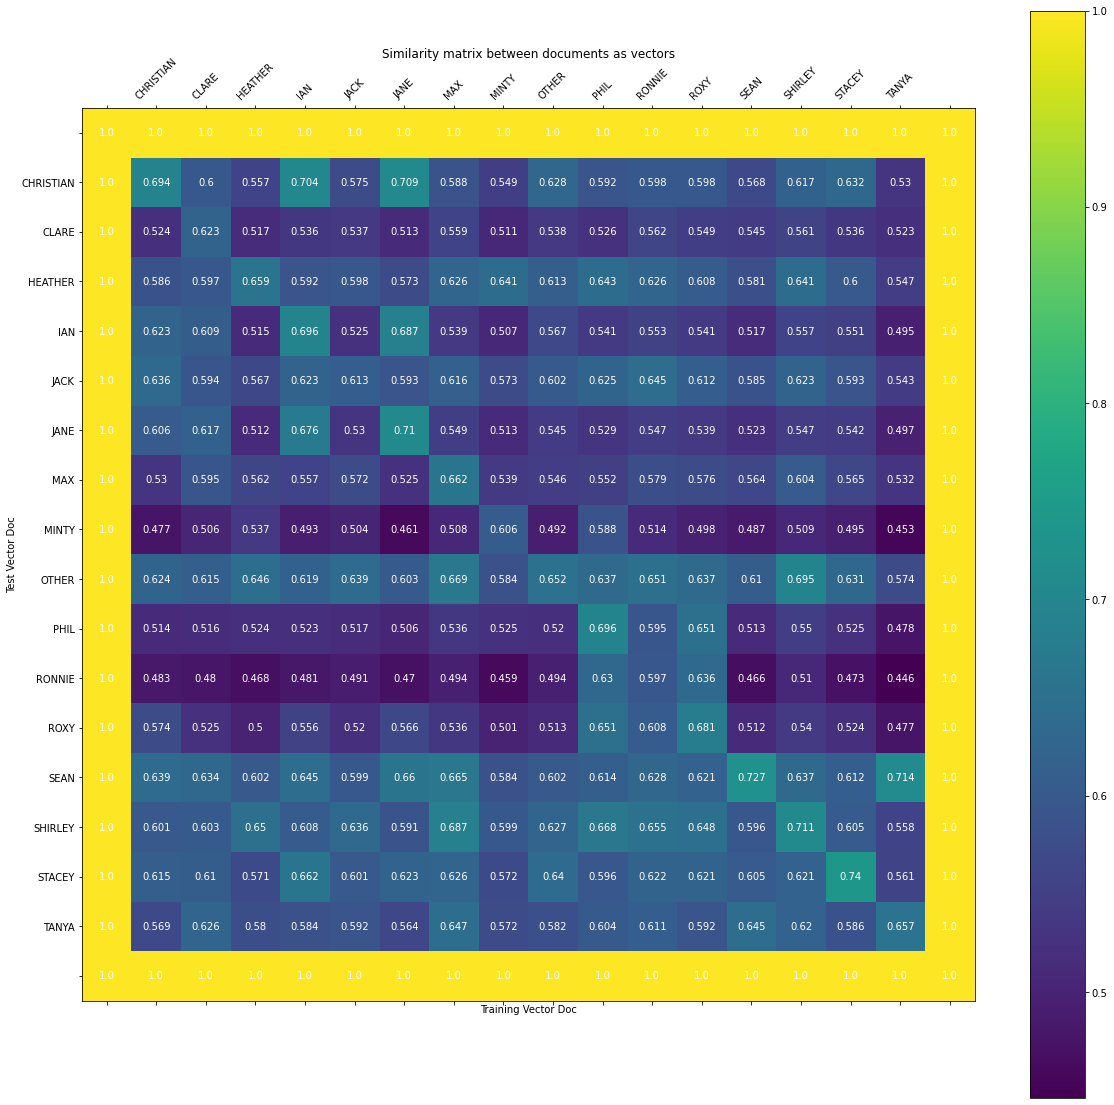

In [540]:
plot_heat_map_similarity(df)

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [541]:
# redo on all training data with the first 400 character lines used
train_character_docs,extra_features = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
epsiode_scene_column = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values])))
test_character_docs,extra_features = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

dict_keys(['SHIRLEY', 'OTHER', 'JACK', 'RONNIE', 'TANYA', 'SEAN', 'ROXY', 'HEATHER', 'MAX', 'IAN', 'JANE', 'STACEY', 'PHIL', 'MINTY', 'CHRISTIAN', 'CLARE'])
lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
dict_keys(['SHIRLEY', 'OTHER', 'HEATHER', 'PHIL', 'SEAN', 'TANYA', 'MAX', 'JACK', 'IAN', 'J